In [1]:
import numpy as np          # linear algebra
import pandas as pd         # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt 
from keras import *
from tensorflow import *
from keras.models import Sequential, load_model
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.layers.core import Dropout, Activation
from keras.layers import Conv2D, BatchNormalization, MaxPool2D, Flatten, \
     Dense, Input, Activation, Dropout, GlobalAveragePooling2D, AveragePooling2D
from keras.utils.np_utils import to_categorical
from sklearn.model_selection import train_test_split
from keras.models import Model
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.python.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
import cv2
from cv2 import imread, resize # manipulating the images
from keras.optimizers import adam_v2
import os

In [2]:
df_skin = pd.read_csv('/kaggle/input/skin-cancer-mnist-ham10000/HAM10000_metadata.csv')
# Display the first 10 lines
df_skin.head(10)


,lesion_id,image_id,dx,dx_type,age,sex,localization
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear
5,HAM_0001466,ISIC_0027850,bkl,histo,75.0,male,ear
6,HAM_0002761,ISIC_0029176,bkl,histo,60.0,male,face
7,HAM_0002761,ISIC_0029068,bkl,histo,60.0,male,face
8,HAM_0005132,ISIC_0025837,bkl,histo,70.0,female,back
9,HAM_0005132,ISIC_0025209,bkl,histo,70.0,female,back


In [3]:
# Lesion/dis names are given in the description of the data set.
lesion_type_dict = {
    'nv': 'Melanocytic nevi',
    'mel': 'Melanoma',
    'bkl': 'Benign keratosis-like lesions ',
    'bcc': 'Basal cell carcinoma',
    'akiec': 'Actinic keratoses',
    'vasc': 'Vascular lesions',
    'df': 'Dermatofibroma'
}

lesion_ID_dict = {
    'nv': 0,
    'mel': 1,
    'bkl': 2,
    'bcc': 3,
    'akiec': 4,
    'vasc': 5,
    'df': 6
}

# Lesion and it's abbriv.
lesion_names = ['Melanocytic nevi','Melanoma','Benign keratosis-like lesions ',
               'Basal cell carcinoma','Actinic keratoses','Vascular lesions',
               'Dermatofibroma']
lesion_names_short = ['nv','mel','bkl','bcc','akiec','vasc','df']

# Maping the lesion type and ID to a dict.
df_skin['lesion_type']=df_skin['dx'].map(lesion_type_dict)
df_skin['lesion_ID'] = df_skin['dx'].map(lesion_ID_dict)

# Display the total found images.
print('Total number of images', len(df_skin))
print('The problem is unbalanced, since Melanocytic nevi is much more frequent that other labels')

# Display the count of each lesion.
df_skin['lesion_type'].value_counts()

Total number of images 10015
The problem is unbalanced, since Melanocytic nevi is much more frequent that other labels


Melanocytic nevi                  6705
Melanoma                          1113
Benign keratosis-like lesions     1099
Basal cell carcinoma               514
Actinic keratoses                  327
Vascular lesions                   142
Dermatofibroma                     115
Name: lesion_type, dtype: int64

['/kaggle/input/skin-cancer-mnist-ham10000/HAM10000_images_part_1/ISIC_0025030.jpg']


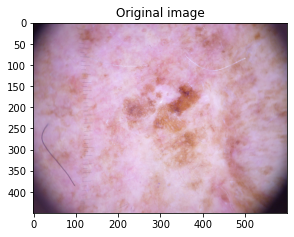

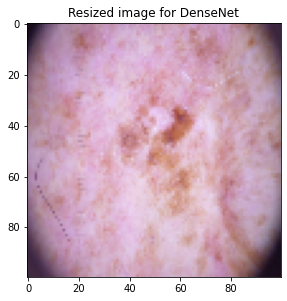

['/kaggle/input/skin-cancer-mnist-ham10000/HAM10000_images_part_1/ISIC_0026769.jpg']


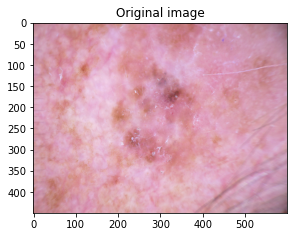

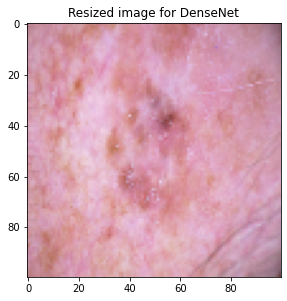

['/kaggle/input/skin-cancer-mnist-ham10000/HAM10000_images_part_1/ISIC_0025661.jpg']


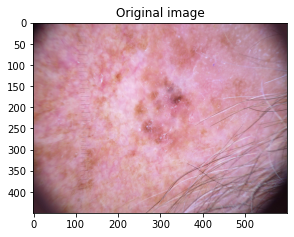

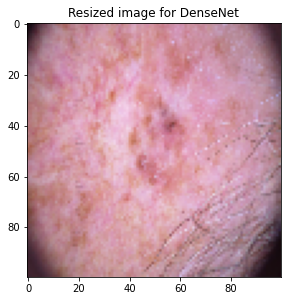

['/kaggle/input/skin-cancer-mnist-ham10000/HAM10000_images_part_1/ISIC_0031633.jpg']
Wrong path:


In [4]:
# Resizing the read image to 100x100

fname_images = np.array(df_skin['image_id'])
# Show one exampe image before and after Resizing 

for i in range (1,5):
  image_path='/kaggle/input/skin-cancer-mnist-ham10000/HAM10000_images_part_1/'+str(fname_images[i])+'.jpg'
  l=[]
  l.append(image_path)
  print(l)  #try printing path of images 
  img_read = imread(image_path)

  if img_read is None:
    print('Wrong path:')
  else:
    
    # original
    plt.figure(figsize = (10, 5)) 
    plt.subplot(1,2,1)
    plt.subplots_adjust(hspace=0.5)
    pixels = np.array(img_read)
    plt.imshow(pixels[:, :, ::-1])
    plt.title('Original image')
    plt.show()

    # resized
    plt.figure(figsize = (10, 5)) 
    plt.subplot(1, 2, 2)
    img2 = resize(img_read, (100, 100))
    pixel = np.array(img2)
    plt.imshow(pixel[:, :, ::-1])
    plt.title('Resized image for DenseNet')
    plt.show()
   


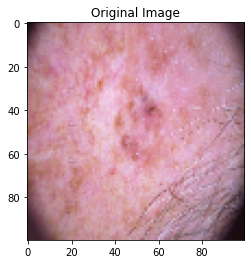

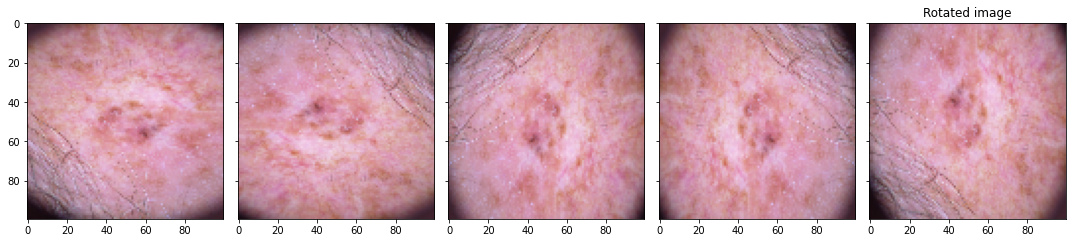

In [5]:
def produce_new_img(img2: cv2) -> tuple:
    """
    function to reproduse a new manipulated (rotating of flipping the original one)
    image from the read one, To increase the dimension of the dataset, avoiding overfitting of a single class.
    """
    imga = cv2.rotate(img2, cv2.ROTATE_90_CLOCKWISE)
    imgb = cv2.rotate(img2, cv2.ROTATE_90_COUNTERCLOCKWISE)
    imgc = cv2.rotate(img2, cv2.ROTATE_180)
    imgd = cv2.flip(img2, 0)
    imge = cv2.flip(img2, 1)
    new_imges = imga, imgb, imgc, imgd ,imge
    return new_imges
def show_example() -> None:
    """
    Display an image after manipulating it in produce_new_img() function
    """
    # Original Image
    plt.imshow(img2[:,:,::-1])
    plt.title("Original Image")
    f, axarr = plt.subplots(1,5,sharex=True, sharey=True, squeeze=True, subplot_kw=None,figsize=(15, 15)) 
    plt.title("Rotated image",loc='center')
    # use the created array to output your multiple images. In this case I have stacked 5  images horizontally
    axarr[0].imshow(new_img[0][:, :, ::-1])
    axarr[1].imshow(new_img[1][:, :, ::-1])
    axarr[2].imshow(new_img[2][:, :, ::-1])
    axarr[3].imshow(new_img[3][:, :, ::-1])
    axarr[4].imshow(new_img[4][:, :, ::-1])
    plt.tight_layout()
    plt.show()

# Invoking our function :)
new_img = produce_new_img(img2)

# printing all 5 new images pixels
'''
for i in range(len(new_img)):
  print(new_img[i])
  print("---------------------------------------------------------------")
'''

# Display an example by invoking show_example func
show_example()

In [6]:
x = []          # Hold resized images.
y = []          # Hold image lesion ID from the data set.

# Listing all files in the part_1, part_2 dirs
lista1 = os.listdir('/kaggle/input/skin-cancer-mnist-ham10000/HAM10000_images_part_1/')
lista2 = os.listdir('/kaggle/input/skin-cancer-mnist-ham10000/HAM10000_images_part_2/')

# [+] Handling images from part 1 directory
for i in range(len(lista1)):
    # [+] Features: reading and resize the photo.
    fname_image = lista1[i]
    fname_ID = fname_image.replace('.jpg', '')
    file_to_read ='/kaggle/input/skin-cancer-mnist-ham10000/HAM10000_images_part_1/' + str(fname_image)  # resolve image name
    img = imread(file_to_read)                                  # read the image 
    img2 = resize(img,(100, 100))                               # resise our image
    x.append(img2)                                              # append the new image to the list x.
    
    # Targets: Finding the image lesion ID and append it to the y list.
    output = np.array(df_skin[df_skin['image_id'] == fname_ID].lesion_ID)
    y.append(output[0])
    
    # add more images for class between 1-6, rotating them 
    if output != 0:
        new_img = produce_new_img(img2)
        for i in range(5):
            x.append(new_img[i])
            y.append(output[0])

    # inform the user with the number of loaded images each 100 img.
    if i % 100 == 0:
        print(i, 'images loaded part 1')


# [+] Handling images from part 2 directory
for i in range(len(lista2)):

    # [+] Features: reading and resize the photo.
    fname_image = lista2[i]
    fname_ID = fname_image.replace('.jpg', '')
    file_to_read ='/kaggle/input/skin-cancer-mnist-ham10000/HAM10000_images_part_2/' + str(fname_image)


    img = imread(file_to_read)
    img2 = resize(img, (100, 100))
    x.append(img2)
    
    # Targets: Finding the image lesion ID and append it to the y list.
    output = np.array(df_skin[df_skin['image_id'] == fname_ID].lesion_ID)
    y.append(output[0])
    
    # [+] Add more images for class between 1-6
    if output != 0:
        new_img = produce_new_img(img2)
        for i in range(5):
            x.append(new_img[i])
            y.append(output[0])
    
    if i % 100 == 0: # [+] Inform the user with the number of loaded images each 100 img.
        print(len(lista1) + i,'images loaded part2')

0 images loaded part 1
100 images loaded part 1
200 images loaded part 1
300 images loaded part 1
400 images loaded part 1
500 images loaded part 1
600 images loaded part 1
700 images loaded part 1
800 images loaded part 1
1100 images loaded part 1
1200 images loaded part 1
1500 images loaded part 1
1600 images loaded part 1
1800 images loaded part 1
2100 images loaded part 1
2300 images loaded part 1
2400 images loaded part 1
2600 images loaded part 1
2700 images loaded part 1
2800 images loaded part 1
2900 images loaded part 1
3000 images loaded part 1
3100 images loaded part 1
3200 images loaded part 1
3500 images loaded part 1
3600 images loaded part 1
3700 images loaded part 1
3900 images loaded part 1
4100 images loaded part 1
4500 images loaded part 1
4600 images loaded part 1
4700 images loaded part 1
4800 images loaded part 1
4900 images loaded part 1
5000 images loaded part2
5100 images loaded part2
5300 images loaded part2
5400 images loaded part2
5700 images loaded part2
59

In [9]:
x = np.array(x)
y = np.array(y)
# convert y (targets) array as required by softmax activation function
y_train = to_categorical(y, num_classes = 7)

In [11]:
x.shape

(26565, 100, 100, 3)

In [23]:
print(y_train)

array([[1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.]], dtype=float32)


In [24]:
# split in 80% training and 20% test data
X_train, X_test, y_train, y_test = train_test_split(x,                  # Images array.
                                                    y_train,            # The training set.
                                                    test_size = 0.20,   # Split data set into 20/80.
                                                    random_state = 50,  # Shuffling number to random the set.
                                                    stratify = y)       # Mix training and test sets.
# [+] Display the count of train/test data set.
print('Train dataset shape', X_train.shape)
print('Test dataset shape', X_test.shape)

Train dataset shape (21252, 100, 100, 3)
Test dataset shape (5313, 100, 100, 3)


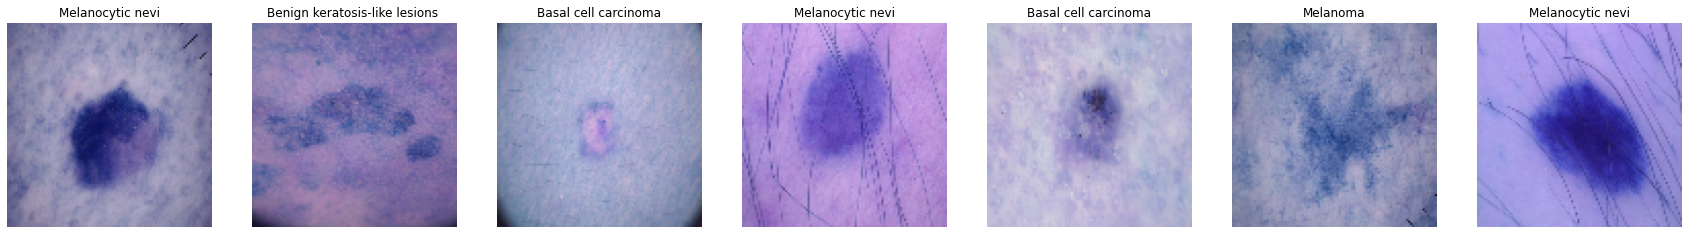

In [25]:
def show_neg_figuers() -> None:
    """ Display negative figuers of the classes. """
    # Figure, Axes
    _, ax = plt.subplots(1, 7, figsize = (30, 30))
    for i in range(7):
        ax[i].set_axis_off()                                    # set the image to negative.
        ax[i].imshow(X_train[i])                                # Display the img.
        ax[i].set_title(lesion_names[np.argmax(y_train[i])])    # Set image title.

show_neg_figuers()


In [26]:
def est_class_weights(dis_id: np.array) -> dict:
    """Estimate class weights for unbalanced datasets.

    Args:
        dis_id (np.array): numpy array of dis IDs

    Returns:
        dict: Estimated class weights for for unbalanced datasets.
    """
    class_weights = np.around(compute_class_weight(class_weight = 'balanced', classes = np.unique(dis_id), y = y), 2)
    class_weights = dict(zip(np.unique(dis_id), class_weights))
    return class_weights

y_id = np.array(df_skin['lesion_ID'])
print(y_id)
new_class_weights = est_class_weights(y_id)
print('The problem is unbalanced. We need to provide class-weights')
print(new_class_weights)


array([2, 2, 2, ..., 4, 4, 1])
The problem is unbalanced. We need to provide class-weights
{0: 0.57, 1: 0.57, 2: 0.58, 3: 1.23, 4: 1.93, 5: 4.45, 6: 5.5}


In [27]:
import keras
from keras.utils.np_utils import to_categorical # used for converting labels to one-hot-encoding
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from keras import backend as K
import itertools
from tensorflow.keras.layers import BatchNormalization
from keras.utils.np_utils import to_categorical # convert to one-hot-encoding

['/kaggle/input/skin-cancer-mnist-ham10000/HAM10000_images_part_1/ISIC_0025030.jpg']


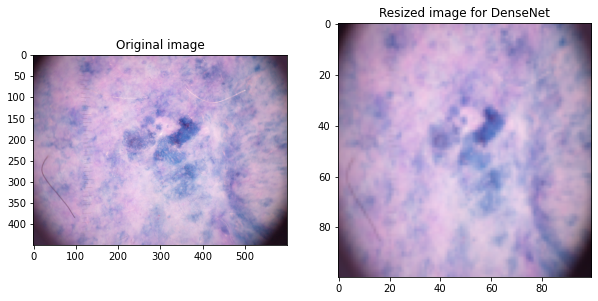

['/kaggle/input/skin-cancer-mnist-ham10000/HAM10000_images_part_1/ISIC_0026769.jpg']


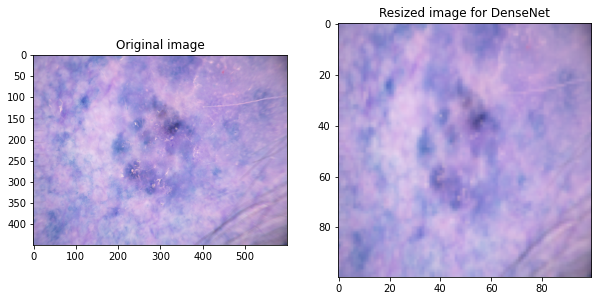

['/kaggle/input/skin-cancer-mnist-ham10000/HAM10000_images_part_1/ISIC_0025661.jpg']


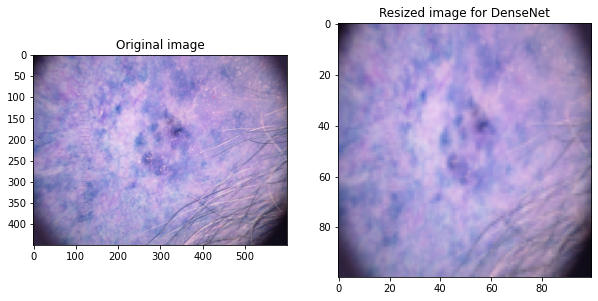

In [28]:
import matplotlib.pyplot as plt
from skimage.io import imread
from skimage.transform import resize

# Resizing the read image to 100x100

fname_images = np.array(df_skin['image_id'])
# Show one exampe image before and after Resizing 

for i in range (1,4):
  image_path='/kaggle/input/skin-cancer-mnist-ham10000/HAM10000_images_part_1/'+str(fname_images[i])+'.jpg'
  l=[]
  l.append(image_path)
  print(l)  #try printing path of images 
  img_read = imread(image_path)

  if img_read is None:
    print('Wrong path:')
  else:
    # Create a 2x2 grid of subplots
    fig, ax = plt.subplots(1, 2, figsize=(10, 10))
    ax = ax.ravel()

    # original
    ax[0].imshow(img_read[:, :, ::-1])
    ax[0].set_title('Original image')

    # resized
    img2 = resize(img_read, (100, 100))
    ax[1].imshow(img2[:, :, ::-1])
    ax[1].set_title('Resized image for DenseNet')
    plt.savefig('Resizing.jpg', dpi=300)
    plt.show()


In [29]:
model = Sequential()
        
# [+] 1st convolutional layer
model.add(Conv2D(filters = 96,
                kernel_size = (11, 11),
                strides = (4, 4),
                activation = 'relu',
                input_shape = (100, 100, 3)))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size = (3, 3), strides = (2, 2)))
# # [+] 2nd convolutional layer


model.add(Conv2D(filters = 256,
                kernel_size=(5, 5),
                strides=(1, 1),
                activation = 'relu',
                padding = "same"))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size = (3, 3), strides = (2, 2)))
# [+] 3nd convolutional layer

model.add(Conv2D(filters = 384,
                 kernel_size=(3,3),
                 strides=(1,1),
                 activation='relu',
                 padding="same"))
model.add(BatchNormalization())
# model.add(MaxPool2D(pool_size = (3, 3), strides = (2, 2)))
# [+] 4th convolutional layer
model.add(Conv2D(filters = 384,
                kernel_size = (1, 1), 
                strides = (1, 1), 
                activation = 'relu', 
                padding = "same"))
model.add(BatchNormalization())
# model.add(MaxPool2D(pool_size = (3, 3), strides = (2, 2)))
# [+] 5th convolutional layer
model.add(Conv2D(filters = 256, 
                kernel_size = (1, 1),
                strides = (1, 1),
                activation = 'relu',
                padding = "same"))
model.add(BatchNormalization())
# model.add(MaxPool2D(pool_size = (3, 3), strides = (2, 2)))
              
model.add(Flatten())  # [+] Convert the Conv2D objects into one List.


# From the Docs: 
# A Dense layer feeds all outputs from the previous layer to all its neurons,
# each neuron providing one output to the next layer.
# source: www.stackoverflow.com
model.add(Dense(4096, activation = 'relu'))
model.add(Dropout(0.5))

# [+] 6th oense layer
model.add(Dense(4096, activation = 'softmax'))
model.add(Dropout(0.5))
# [+] 7th output layer
model.add(Dense(7, activation = 'softmax'))

In [ ]:
def mod_checkpoint_callback() -> None:
    """
    Saving our model
    
    Returns:
        None: Saving a checkpoint of the model.
    """
    trained_model = ModelCheckpoint(filepath = 'model_80_20_200.h5',  # result file name
                             save_weights_only = False,     # Save all training results/params.
                             monitor = 'val_accuracy',      # check our model accuracy if it's step forward.
                             mode = 'max',                 # enable auto save.
                             save_best_only = True,         # if ac_new > ac_old
                             verbose = 1)
    return trained_model

# Montoring the training procces in each epoch.
early_stopping_monitor = EarlyStopping(patience = 100, monitor = 'val_accuracy')
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
model_checkpoint_callback = mod_checkpoint_callback()
# Estimate the model data if it was big one.
optimizer = Adam(learning_rate = 0.001, beta_1 = 0.9, beta_2 = 0.999, epsilon = 1e-3)
model.compile(optimizer = optimizer, loss = 'categorical_crossentropy', metrics = ['accuracy'])
# datagen = ImageDataGenerator(rescale = 1./255,
#                                   rotation_range = 10,
#                                   width_shift_range = 0.2,
#                                   height_shift_range = 0.2,
#                                   shear_range = 0.2,
#                                   horizontal_flip = True,
#                                   vertical_flip = True,
#                                   fill_mode = 'nearest')
datagen = ImageDataGenerator(zoom_range = 0.2, horizontal_flip = True, shear_range = 0.2)
datagen.fit(X_train)

batch_size = 16  # samples in the network at once.
epochs = 200   # epochs number.

# org model result data
history = model.fit(datagen.flow(X_train,y_train),
                    epochs = epochs,
                    batch_size = batch_size,
                    shuffle = True,
                    callbacks = [early_stopping_monitor, model_checkpoint_callback],
                    validation_data = (X_test, y_test),
                    class_weight = new_class_weights
                )

Epoch 1/200
665/665 [==============================] - 53s 78ms/step - loss: 1.9247 - accuracy: 0.1971 - val_loss: 1.8450 - val_accuracy: 0.2780

Epoch 00001: val_accuracy improved from -inf to 0.27800, saving model to model_80_20_200.h5
Epoch 2/200
665/665 [==============================] - 51s 77ms/step - loss: 1.8860 - accuracy: 0.2230 - val_loss: 1.8780 - val_accuracy: 0.2488

Epoch 00002: val_accuracy did not improve from 0.27800
Epoch 3/200
665/665 [==============================] - 51s 76ms/step - loss: 1.8921 - accuracy: 0.2543 - val_loss: 1.8006 - val_accuracy: 0.2535

Epoch 00003: val_accuracy did not improve from 0.27800
Epoch 4/200
665/665 [==============================] - 51s 76ms/step - loss: 1.8830 - accuracy: 0.2019 - val_loss: 1.7806 - val_accuracy: 0.2588

Epoch 00004: val_accuracy did not improve from 0.27800
Epoch 5/200
665/665 [==============================] - 52s 78ms/step - loss: 1.9050 - accuracy: 0.1929 - val_loss: 1.8775 - val_accuracy: 0.1613

Epoch 00005: 

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Epoch 41/200
665/665 [==============================] - 51s 76ms/step - loss: 1.8986 - accuracy: 0.2316 - val_loss: 1.8724 - val_accuracy: 0.2505

Epoch 00041: val_accuracy did not improve from 0.30849
Epoch 42/200
665/665 [==============================] - 49s 74ms/step - loss: 1.8915 - accuracy: 0.2407 - val_loss: 1.8181 - val_accuracy: 0.2524

Epoch 00042: val_accuracy did not improve from 0.30849
Epoch 43/200
665/665 [==============================] - 50s 76ms/step - loss: 1.8935 - accuracy: 0.1917 - val_loss: 1.8611 - val_accuracy: 0.2765

Epoch 00043: val_accuracy did not improve from 0.30849
Epoch 44/200
665/665 [==============================] - 50s 75ms/step - loss: 1.8906 - accuracy: 0.2004 - val_loss: 1.8364 - val_accuracy: 0.2462

Epoch 00044: val_accuracy did not improve from 0.30849
Epoch 45/200
665/665 [==============================] - 51s 76ms/step - loss: 1.8927 - accuracy: 0.1679 - val_loss: 1.8188 - val_accuracy: 0.3109

Epoch 00045: val_accuracy improved from 0.308

In [ ]:
# [+] inform the user with model Accuracy %
scores = model.evaluate(X_test, y_test, verbose = 1)
print("Accuracy: %.2f%%" % (scores[1] * 100))

In [ ]:
def display_accuracy() -> None:
    # Summarize history for accuracy
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['accuracy', 'val_accuracy'], loc='upper left')
    plt.show()

def display_loss() -> None:
    # Summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

display_accuracy()
display_loss()

In [ ]:
y_pred = model.predict(X_test)

def test_model() -> tuple:
    """ Tunning the accurate results and inaccurate results
    Returns:
        (total, accurate) [tuple]: tuple of total tested test-cases, accurate
    """
    total = 0
    accurate = 0
    accurateindex = []
    wrongindex = []
    for i in range(len(y_pred)):
        if np.argmax(y_pred[i]) == np.argmax(y_test[i]):
            accurate += 1
            accurateindex.append(i)
        else:
            wrongindex.append(i)
        total += 1
    return (total, accurate)

total, accurate = test_model()
print('Total-test-data;', total, '\taccurately-predicted-data:', accurate, '\t wrongly-predicted-data: ', total - accurate)
print('Accuracy:', round(accurate / total * 100, 3), '%')

this was the model we got from epoch 10... Now we will see the best model saved before finishing the training..

In [ ]:
import tensorflow as tf
# model1 = load_model('https://drive.google.com/file/d/1IBZCCPuGxjGWk2Y92GIqf-CwEz1U6p_A/view?usp=share_link')
model1=tf.keras.models.load_model('model_80_20_200.h5')

# Compute predictions
y_pred_prob = np.around(model1.predict(X_test),3)
y_pred1 = np.argmax(y_pred_prob, axis = 1)
y_test2_1 = np.argmax(y_test, axis = 1)

In [ ]:
# best_model = load_model('/kaggle/working/model_80_20_100.h5')

# # Compute predictions
# y_pred_prob = np.around(best_model.predict(X_test),3)
# y_pred = np.argmax(y_pred_prob, axis = 1)
# y_test2 = np.argmax(y_test, axis = 1)

In [ ]:
# [+] inform the user with model Accuracy %
scores = model1.evaluate(X_test, y_test, verbose = 1)
print("Accuracy: %.2f%%" % (scores[1] * 100))

In [ ]:
# # [+] inform the user with model Accuracy %
# scores = best_model.evaluate(X_test, y_test, verbose = 1)
# print("Accuracy: %.2f%%" % (scores[1] * 100))

In [ ]:
plt.figure(figsize=(16,16))
for i in range(16):
    plt.subplot(4,4,5)
    index = i+100
    plt.imshow(X_test[index,:,:,::-1])
    label_exp = lesion_names[y_test2_1[index]]  #expected label
    label_pred = lesion_names[y_pred1[index]]  #predicted label
    label_pred_prob = round(np.max(y_pred_prob[index])*100)
    plt.title('Expected:'+str(label_exp)+'\n Pred.:'+str(label_pred)+' ('+str(label_pred_prob)+'%)')
plt.ylabel('')
plt.tight_layout()
plt.savefig('final_figure.png',dpi=300)
plt.show()

In [ ]:
# #Accuracy for each type
# acc_tot= []

# for i in range(7):
#     acc_parz = round(np.mean(y_test2[y_test2 == i] == y_pred[y_test2 == i]),2)
#     lab_parz = lesion_names[i]
#     print('accuracy for',lab_parz,'=',acc_parz)
#     acc_tot.append(acc_parz)

In [ ]:
# acc_tot = np.array(acc_tot)
# freq = np.unique(y_test2,return_counts=True)[1]

# np.sum(acc_tot*freq)/np.sum(freq)

In [ ]:
#Accuracy for each type
acc_tot1= []

for i in range(7):
    acc_parz = round(np.mean(y_test2_1[y_test2_1 == i] == y_pred1[y_test2_1 == i]),2)
    lab_parz = lesion_names[i]
    print('accuracy for',lab_parz,'=',acc_parz)
    acc_tot1.append(acc_parz)

In [ ]:
acc_tot1 = np.array(acc_tot1)
freq = np.unique(y_test2_1,return_counts=True)[1]

np.sum(acc_tot1*freq)/np.sum(freq)

In [ ]:
X_test[5]

In [ ]:
X_train[5]

In [ ]:
plt.figure(figsize=(16,16))
import tensorflow as tf

for i in range(16):
    
    # Define a tensor with the value 1
    i= tf.constant(1)

    # Evaluate the tensor to obtain its numerical value
    i = i.numpy()
    plt.subplot(4,4,i+1)
    index = i+100
    plt.imshow(X_test[index,:,:,::-1])
    label_exp = lesion_names[y_test2_1[index]]  #expected label
    label_pred = lesion_names[y_pred1[index]]  #predicted label
    label_pred_prob = round(np.max(y_pred_prob[index])*100)
    plt.title('Expected:'+str(label_exp)+'\n Pred.:'+str(label_pred)+' ('+str(label_pred_prob)+'%)')
plt.ylabel('')
plt.tight_layout()
plt.savefig('final_figure1.png',dpi=300)
plt.show()

In [ ]:
import matplotlib.pyplot as plt

# Create the figure
fig, axes = plt.subplots(4, 4, figsize=(16,16))

# Flatten the array of axes to make indexing easier
axes = axes.ravel()

for i in range(16):
    # Add the subplot to the figure
    ax = axes[i]
    index = i + 100
    ax.imshow(X_test[index,:,:,::-1])
    label_exp = lesion_names[y_test2_1[index]]  #expected label
    label_pred = lesion_names[y_pred1[index]]  #predicted label
    label_pred_prob = round(np.max(y_pred_prob[index])*100)
    
    ax.set_title('Expected:'+str(label_exp)+'\n Pred.:'+str(label_pred))

plt.tight_layout()
plt.savefig('final_figure.png', dpi=300)
plt.savefig('fig.jpg', dpi=300)
plt.show()


In [ ]:
plt.savefig('Resizing.jpg', dpi=300)